# A. Wave analysis - Majuro Atoll (Republic of the Marshall Islands)

## Analysis of Time Series. Waves in Coastal Waters

<div class="admonition" style="border: 2px solid #C798FB; background-color: rgba(199, 152, 251, 0.1); padding: 10px; border-radius: 5px;">
    <i class="fas fa-info-circle" style="color: #ffa502;"></i>
    <strong>Information</strong>
    <ul>For this study, 1-second data were collected from four pressure sensors deployed during the winter season of 2016-2017 (from mid-November until early February) by Murray Ford (University of Auckland). These pressure sensors were located in the lagoon as shown in the figure bellow; sensors 41320 (tidal gauge) and 41323 were placed closely at the east-side lagoon shoreline, 41321 is situated in the middle of the lagoon and 41322 in front of the shipping channe
    </ul>
</div>


In [2]:
# os
import os
import os.path as op
import sys

# arrays
import math
import numpy as np
import pandas as pd
from scipy import signal as sg
import plotly.express as px

# plot
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies
from lib.eta_spec import *

In [3]:
import warnings
warnings.filterwarnings("ignore")
colors = px.colors.qualitative.Plotly

**Path to pressure data**

In [4]:
p_data = op.abspath(op.join(os.getcwd(),'..', '..','..', 'data', 'Majuro'))

p_pressure = op.join(p_data, 'Pressure')

**Majuro lagoon and pressure sensors location**


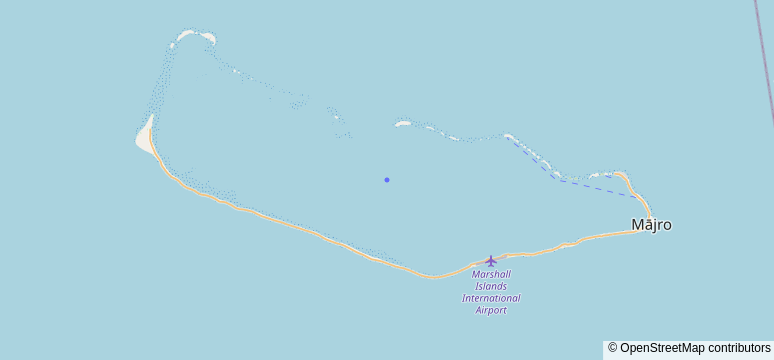

In [16]:
fig = px.scatter_mapbox(
    pd.DataFrame({'lon': [171.2], 'lat': [7.12]}), lon="lon",  lat="lat",
    mapbox_style='open-street-map',
    zoom=10
)
fig.update_layout(margin={'r':0, 'l':0, 't': 0, 'b':0})
fig.show()

**Load data**


In [4]:
# Murray sensors  -->  sea pressure (1-sec data)
sensor = xr.open_dataset(p_pressure + '/Data_41321_pressure')
sensor

<xarray.Dataset>
Dimensions:       (time: 6739200)
Coordinates:
  * time          (time) datetime64[ns] 2016-11-18 ... 2017-02-03T23:59:59
Data variables:
    Depth         (time) float64 ...
    Sea_Pressure  (time) float64 ...

## A.1 Observations

### Time Series: Months

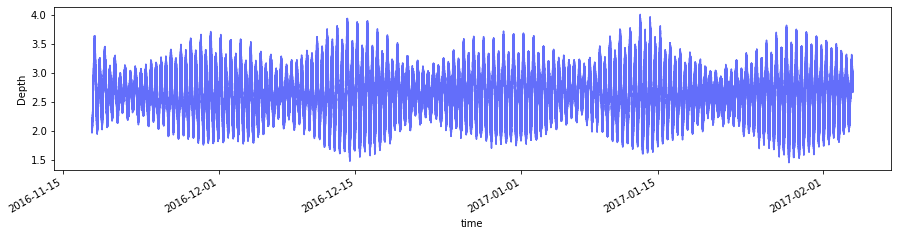

In [5]:
sensor.Depth.plot(c=colors[0], figsize=(15, 3))

<div class="admonition" style="border: 2px solid #C798FB; background-color: rgba(199, 152, 251, 0.1); padding: 10px; border-radius: 5px;">
    <i class="fas fa-info-circle" style="color: #ffa502;"></i>
    <strong>Information</strong>
    <ul><li>For a stationary surface elevation signal the mean should be constant
        <li>The standard deviation ($\sigma$) is a vertical measure that can be related to the wave height. It is related to the mean wave energy per unit area
    </ul>
</div>


In [15]:
print("Mean:              ", np.mean(sensor.Depth.values))
print("Standar Deviation: ", np.var(sensor.Depth.values))

Mean:               2.6380446707445464
Standar Deviation:  0.185952843311758


### Time Series: A Day

In [6]:
fecha_inicial = '2016-12-15T00:00:00.000000000'
fecha_final = '2016-12-16T00:00:00.000000000'

Text(0.5, 0, 'Time (1s sampling interval)')

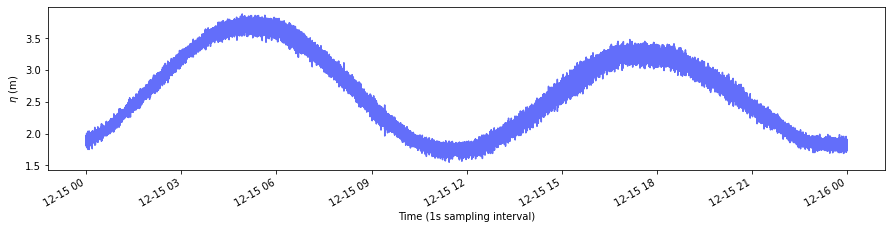

In [7]:
sensor.sel(time=slice(fecha_inicial, fecha_final)).Depth.plot(c=colors[0], figsize=(15, 3))
plt.ylabel('$\eta$ (m)')
plt.xlabel('Time (1s sampling interval)')

### Time Series: An Hour

In [8]:
fecha_inicial = '2016-12-15T00:00:00.000000000'
fecha_final = '2016-12-15T01:00:00.000000000'

Text(0.5, 0, 'Time (1s sampling interval)')

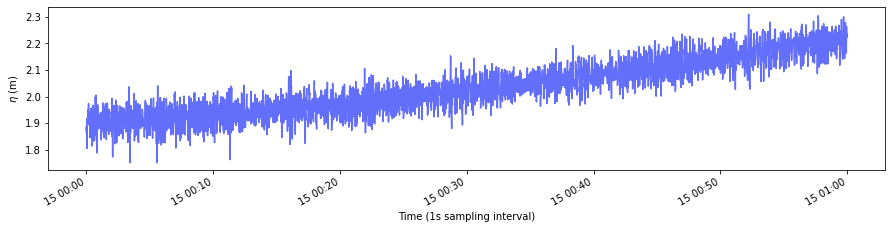

In [9]:
sensor.sel(time=slice(fecha_inicial, fecha_final)).Depth.plot(c=colors[0], fig size=(15, 3))
plt.ylabel('$\eta$ (m)')
plt.xlabel('Time (1s sampling interval)')

### Time Series: A minute

In [10]:
fecha_inicial = '2016-12-15T00:00:00.000000000'
fecha_final = '2016-12-15T00:01:00.000000000'

Text(0.5, 0, 'Time (1s sampling interval)')

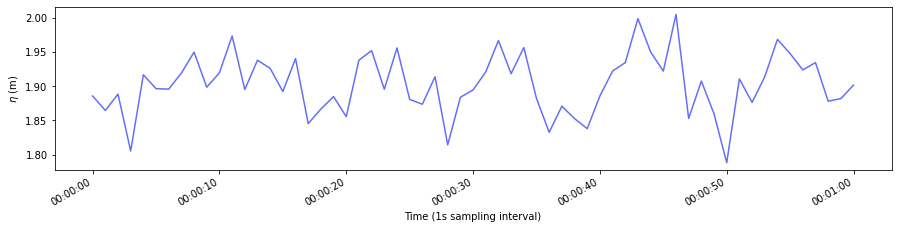

In [11]:
sensor.sel(time=slice(fecha_inicial, fecha_final)).Depth.plot(c=colors[0], figsize=(15, 3))
plt.ylabel('$\eta$ (m)')
plt.xlabel('Time (1s sampling interval)')

`Wave parameters: H, T, L`

## A.2 Signal Processing

**Short-period Waves**

In [12]:
# Calculate spectra help(sg.welch)
f, E = sg.welch(sensor.Depth.values, fs = 1, nfft = 1024)

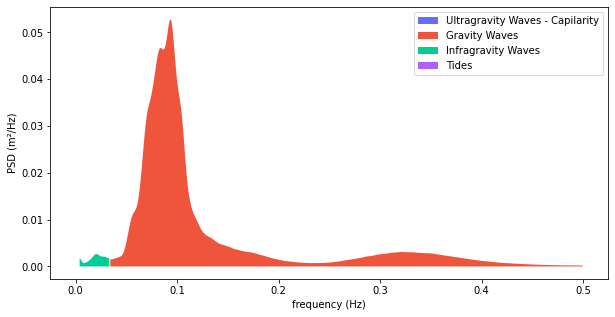

In [13]:
# Plot wave spectrum
plt.figure(figsize=(10,5))
plt.fill_between(f[np.where(1/f < 1)], E[np.where(1/f < 1)], label='Ultragravity Waves - Capilarity', fc=colors[0])
plt.fill_between(f[np.where((1/f > 1) & (1/f < 30))], E[np.where((1/f > 1) & (1/f < 30))], label='Gravity Waves', fc=colors[1])
plt.fill_between(f[np.where((1/f > 30) & (1/f < 5*60))], E[np.where((1/f > 30) & (1/f < 5*60))], label='Infragravity Waves', fc=colors[2])
plt.fill_between(f[np.where((1/f > 10000))], E[np.where((1/f > 10000))], label='Tides', fc=colors[3])

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

**Long-period Tides**

In [14]:
# Calculate spectra help(sg.welch)
f, E = sg.welch(sensor.resample(time='1H').mean().Depth.values, fs = 1, nfft = 1024)

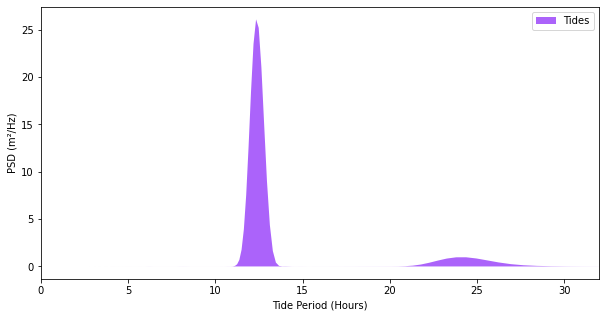

In [15]:
plt.figure(figsize=(10,5))

plt.fill_between(1/f, E, label='Tides', fc=colors[3])
plt.xlim(0, 32)

plt.xlabel('Tide Period (Hours)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

## A.3 Signal Decomposition

In [16]:
import utide

In [17]:
sensor_hour = sensor.resample(time='1H').mean()

In [18]:
coef = utide.solve(
    sensor_hour.time.values, sensor_hour['Depth'].values,
    lat=7.09,
    nodal=True,
    method='ols',
    conf_int='MC',
    trend=False,
)


solve: matrix prep ... solution ... done.


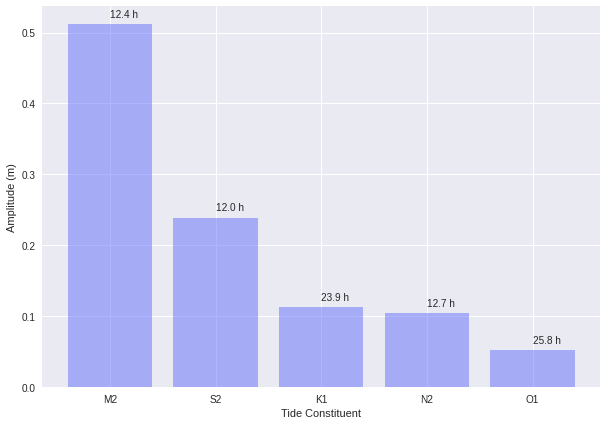

In [57]:
plt.figure(figsize=(10,7))
plt.bar(coef['name'][:5], coef['A'][:5], fc=colors[0], alpha=0.5)
for pcomp, comp in enumerate(coef['aux']['frq'][:5]):
    plt.text(coef['name'][pcomp], coef['A'][pcomp] + 0.01, '{0} h'.format(np.round(1/comp, 1)))
plt.xlabel('Tide Constituent')
plt.ylabel('Amplitude (m)')
plt.show()

In [58]:
tide_tt = utide.reconstruct(sensor_hour.time.values, coef).h

sensor_hour['AT'] = (('time'), tide_tt)

prep/calcs ... done.


In [59]:
sensor_hour = sensor_hour.resample(time='1S').interpolate('linear')[['AT']]

In [60]:
cm, cm1, cm2 = np.intersect1d(sensor_hour.time, sensor.time, return_indices=True)
sensor_hour = sensor_hour.sel(time=cm)
sensor = sensor.sel(time=cm)
sensor['eta'] = sensor.Depth - sensor_hour.AT

### A.3.1 Exploratory Data Analysis

In [61]:
# waves: irregular, random waves
# tide: regular, periodic waves

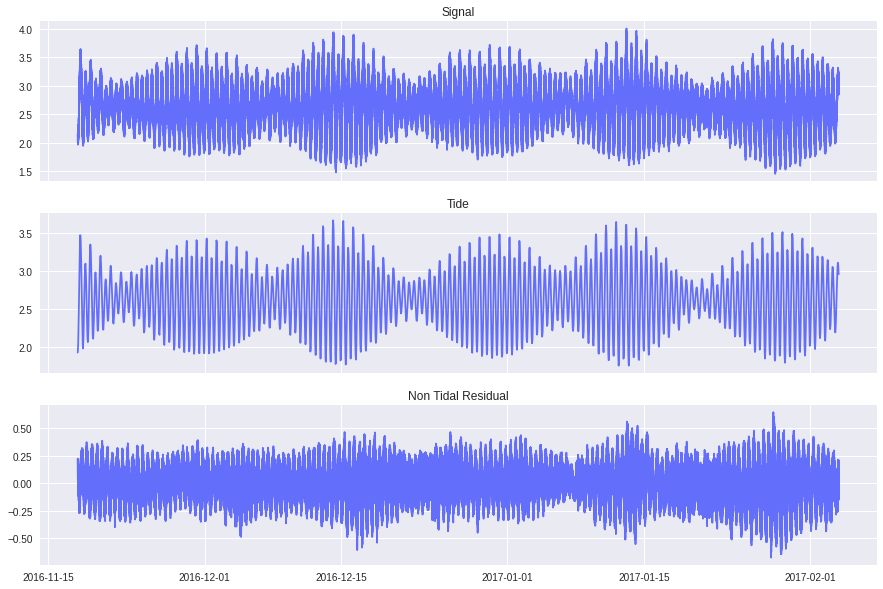

In [82]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15,10))
axs[0].plot(sensor.time, sensor.Depth, c=colors[0])
axs[1].plot(sensor_hour.time, sensor_hour.AT, c=colors[0])
axs[2].plot(sensor.time, sensor.eta, c=colors[0])

axs[0].set_title('Signal')
axs[1].set_title('Tide')
axs[2].set_title('Non Tidal Residual')
plt.show()

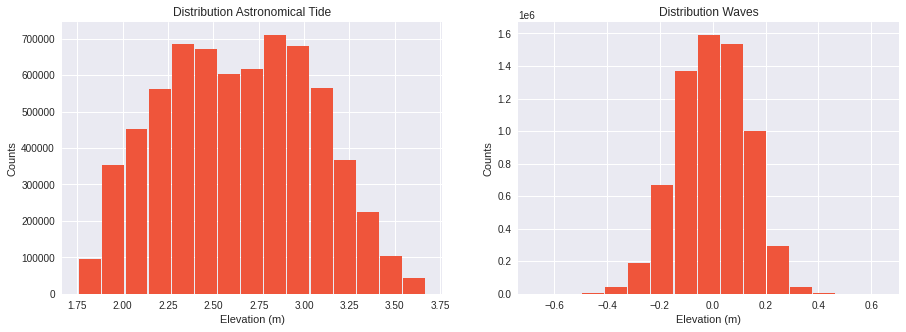

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
_ = axs[0].hist(sensor_hour.AT, rwidth=0.95, fc=colors[1], bins=15)
_ = axs[1].hist(sensor.eta, rwidth=0.95, fc=colors[1], bins=15)
axs[0].set_title('Distribution Astronomical Tide')
axs[1].set_title('Distribution Waves')
axs[0].set_xlabel('Elevation (m)')
axs[1].set_xlabel('Elevation (m)')
axs[0].set_ylabel('Counts')
axs[1].set_ylabel('Counts')
plt.show()

## A.4 Short-term statistics

<div class="admonition" style="border: 2px solid #C798FB; background-color: rgba(199, 152, 251, 0.1); padding: 10px; border-radius: 5px;">
    <i class="fas fa-info-circle" style="color: #ffa502;"></i>
    <strong>Short-term Analysis</strong>
    <ul><li>Description of wave characteristics by taking average parameters
<li>Stationary conditions - the statistics can be considered constant in time
    </ul>
</div>


In [42]:
# A sea-state Select 1 hour

In [70]:
fecha_inicial = '2016-12-15T00:00:00.000000000'
fecha_final = '2016-12-15T01:00:00.000000000'

sensor_h = sensor.sel(time=slice(fecha_inicial, fecha_final))

In [71]:
fs = 1
T, H = upcrossing(sensor_h.eta.values, fs)

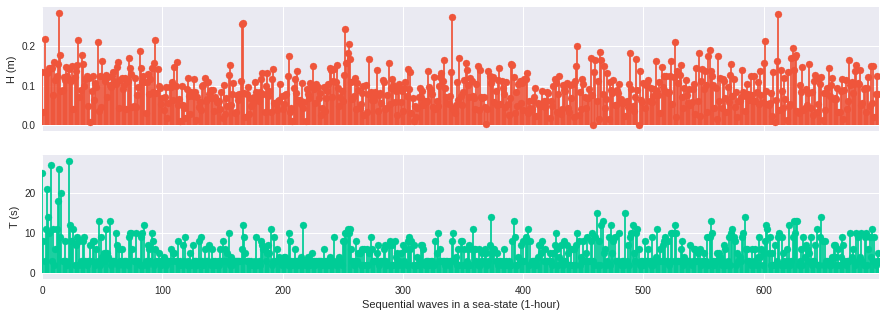

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
axs[0].vlines(range(len(H)), np.full(len(H), 0), H, color=colors[1])
axs[1].vlines(range(len(T)), np.full(len(T), 0), T, color=colors[2])
axs[0].scatter(range(len(H)), H, color=colors[1])
axs[1].scatter(range(len(T)), T, color=colors[2])

axs[0].set_ylabel('H (m)')
axs[1].set_ylabel('T (s)')
axs[1].set_xlabel('Sequential waves in a sea-state (1-hour)')
axs[0].set_xlim(0, len(H))
plt.show()

**Wave height statistics**

`mean wave heigh` $\overline H$

$\overline H = \frac{1}{N} \sum_{i=1}^{N} H_{i}$ <br> where i is the sequence number (in time) of the wave in the record

`root-mean-square wave height` $H_{rms}$

$H_{rms}=(\frac{1}{N} \sum_{i=1}^{N} H_{i}^{2})^{1/2}$

`significant wave heigh` $H_{1/3}$

$H_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} H_{j}$ <br> where j is the rank number of the wave, based on wave-heigh

`mean of the highest one-tenth of waves` $H_{1/10}$

$H_{1/10}=\frac{1}{N/10} \sum_{j=1}^{N/10} H_{j}$ 

`mean zero-crossing wave period` $\overline T_{0}$

$\overline T_{0}=\frac{1}{N} \sum_{i=1}^{N} T_{0,i}$

`significant wave period` $T_{1/3}$

$T_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} T_{0,j}$

In [81]:
# mean wave height
print("mean wave height:                        " + str(np.round(np.mean(H), 2)))

# root-mean-square wave height
print("root-mean-square wave height:            " + str(np.round(rmsV(H), 2)))

# significant wave heigh
print("significant wave height:                 " + str(np.round(highestN_stats(H, 3), 2)))

mean wave height:                        0.09
root-mean-square wave height:            0.1
significant wave height:                 0.14
